<a href="https://colab.research.google.com/github/db495/phase_4_project/blob/main/Sentiment_Classification_Model_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Final Project Submission
**Student name:** David Boyd

**Student pace:** Self paced

**Scheduled project review date/time:** 9/05/2023 21:00 UK time

**Instructor name:** Abhineet

## Business Objective

We want to build a model that helps to identify via tweets whether there was a positive, negative or neutral sentiment  in the messsage, either towards a brand or a product/app. The dataset we are using focuses on 9000 different tweets that happened during SXSW event and has four different options of sentiment these are:
- Positive
- Negative
- Neutral/neither positive nor negative
- I can't tell

## Data Understanding

The dataset comes from CrowdFlower via data.worldLinks. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither, which can be found in tweets_dataset.csv in the data folder in this repository. The dataset includes 9,092 entries, and 3 columns. Here are the columns in the dataset including our target variable, sentiment

- `tweet_text` - The column contains the contents of the tweet that was captured
- `emotion_in_tweet_is_directed_at` - This column identifies whether the tweet was targeted to a brand or a specific product. There are a lot of NULL values in this column, so it's not super helpful initially
- `is_there_an_emotion_directed_at_a_brand_or_product` - This column helps to identify the sentiment of the tweet

## Importing packages & EDA

In [ ]:
## installing all the packages used throughout the notebook
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn import metrics

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
## Uploading the file
from google.colab import files
uploaded = files.upload()

Saving tweets_dataset.csv to tweets_dataset.csv


In [ ]:
## Reading the file into a dataframe
import io
df = pd.read_csv(io.BytesIO(uploaded['tweets_dataset.csv']))


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [ ]:
list = ['emotion_in_tweet_is_directed_at','is_there_an_emotion_directed_at_a_brand_or_product']

## Helping to identify what are all the categories that are listed inside each of the columns that isn't the tweet text itself
for item in list:
    print(f'The column name is {item}')
    print(df[item].unique())
    print(df[item].value_counts())

The column name is emotion_in_tweet_is_directed_at
['iPhone' 'iPad or iPhone App' 'iPad' 'Google' nan 'Android' 'Apple'
 'Android App' 'Other Google product or service'
 'Other Apple product or service']
iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64
The column name is is_there_an_emotion_directed_at_a_brand_or_product
['Negative emotion' 'Positive emotion'
 'No emotion toward brand or product' "I can't tell"]
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, 

In [ ]:
## Removing the records which have an unknown sentiment option - Keeping the options to just Positive, Negative & Neutral
df = df[~df['is_there_an_emotion_directed_at_a_brand_or_product'].isin(['I can\'t tell'])]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8937 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8936 non-null   object
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8937 non-null   object
dtypes: object(3)
memory usage: 279.3+ KB


We can see above that the second column has a large amount of missing data, so we ignore this column and focus only on the other two columns as shown below.

In [ ]:
tweet_df = df[['tweet_text', 'is_there_an_emotion_directed_at_a_brand_or_product']].copy()

## Renaming columns to make easier to read
tweet_df.columns = ['tweet_text', 'sentiment_classification']

tweet_df.head()

,tweet_text,sentiment_classification
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [ ]:
## Helping to encode the labels and store them in a dictionary for future lookup process
tweet_df['category_id'] = tweet_df['sentiment_classification'].factorize()[0]
category_id_df = tweet_df[['sentiment_classification', 'category_id']].drop_duplicates()


In [ ]:
# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'sentiment_classification']].values)

tweet_df.head()


,tweet_text,sentiment_classification,category_id
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,1


We've created a litte dictionary that maps the encoded value to the name of the class so we can better reference our performance later on once we are in the modelling/evaluation phases.

In [ ]:
id_to_category

{0: 'Negative emotion',
 1: 'Positive emotion',
 2: 'No emotion toward brand or product'}

In [ ]:
## dropping all null value columns
tweet_df.dropna()

,tweet_text,sentiment_classification,category_id
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,1
...,...,...,...
9088,Ipad everywhere. #SXSW {link},Positive emotion,1
9089,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product,2
9090,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product,2
9091,Some Verizon iPhone customers complained their...,No emotion toward brand or product,2


In [ ]:
## Converting the tweet text into str format, otherwise the tokenising of the text doesn't work later on
tweet_df['tweet_text'].dropna(inplace=True)
tweet_df['tweet_text'] = tweet_df['tweet_text'].astype(str)

In [ ]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8937 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   tweet_text                8937 non-null   object
 1   sentiment_classification  8937 non-null   object
 2   category_id               8937 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 279.3+ KB


## EDA - Understanding which terms has highest correlation with each category

In [ ]:
tf_idf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each tweet into a vector
features = tf_idf.fit_transform(tweet_df.tweet_text.values.astype('U')).toarray()


labels = tweet_df.category_id

print("Each of the %d tweets is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))


Each of the 8937 tweets is represented by 4603 features (TF-IDF score of unigrams and bigrams)


In [ ]:
# Finding the five most correlated terms with each of the product categories
N = 5
for sentiment_classification, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tf_idf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(sentiment_classification))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))



==> Negative emotion:
  * Most Correlated Unigrams are: classiest, fail, headaches, hate, fascist
  * Most Correlated Bigrams are: design headaches, news apps, fascist company, ipad news, company america

==> No emotion toward brand or product:
  * Most Correlated Unigrams are: begins, app, awesome, wins, cool
  * Most Correlated Bigrams are: comes cool, quot apple, begins apple, wins sxsw, apple wins

==> Positive emotion:
  * Most Correlated Unigrams are: comes, begins, awesome, wins, cool
  * Most Correlated Bigrams are: comes cool, apple comes, begins apple, wins sxsw, apple wins


Above we wanted to explore the dataset prior to the pre-processing stage to see what terms are the most correlated for each class. As we can see, when looking at the bi-grams for positive vs neutral tweets, they remain the same. This is interesting as it might impact overall model performance later on, if it is hard to separate out positive and neutral sentiment tweets.

## Baseline Model

We now move on to evaluating our baseline model performance. As a result, we want to trying several different transformation methods such as Count Vectorizer, Tf-idf Vectorizer and also to see the bi/tri-grams of each tweet.

We first split our data into training and testing sets and then using a function, we look at evaluating performance of each transformation method when building a multinomial naive bayes classification model.

In [ ]:
X = tweet_df['tweet_text'].astype(str)
y = tweet_df['category_id']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42, stratify=y)

### Tf-Idf and count Vectorisation

In [ ]:
# creating a count 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{1,}')
count_vect.fit(tweet_df['tweet_text'].values.astype('U'))

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(X_train.values.astype('U'))
xtest_count =  count_vect.transform(X_test.values.astype('U'))


In [ ]:
# word-level tf-idf
tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=4000)
tfidf.fit(tweet_df['tweet_text'].values.astype('U'))
xtrain_tfidf =  tfidf.transform(X_train.values.astype('U'))
xtest_tfidf =  tfidf.transform(X_test.values.astype('U'))

# ngram (bi, tri)-level tf-idf
tfidf_ngram = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', ngram_range = (2,3) , max_features=4000)
tfidf_ngram.fit(tweet_df['tweet_text'].values.astype('U'))
xtrain_tfidf_ngram =  tfidf_ngram.transform(X_train.values.astype('U'))
xtest_tfidf_ngram =  tfidf_ngram.transform(X_test.values.astype('U'))

In [ ]:
def train_model(classifier, train_df, label, test_df):
    
    # fit the training dataset on the classifier
    classifier.fit(train_df, label)
    
    # predict the labels on test dataset
    predictions = classifier.predict(test_df)
    
    return metrics.accuracy_score(predictions, y_test), metrics.recall_score(predictions, y_test, average='macro')

In [ ]:
# Naive Bayes on Count Vectors
accuracy1, recall1 = train_model(MultinomialNB(), xtrain_count, y_train, xtest_count)
print("NB, Count Vectors: ", accuracy1)
print("NB, Recall - Count Vectors: ", recall1)

NB, Count Vectors:  0.7013422818791947
NB, Recall - Count Vectors:  0.6056150937667525


In [ ]:
# Naive Bayes on Word Level TF IDF Vectors
accuracy2, recall2 = train_model(MultinomialNB(), xtrain_tfidf, y_train, xtest_tfidf)
print("NB, WordLevel TF-IDF: ", accuracy2)
print("NB, Recall - WordLevel TF-IDF: ", recall2)

NB, WordLevel TF-IDF:  0.6817673378076062
NB, Recall - WordLevel TF-IDF:  0.7922770640823379


In [ ]:
# Naive Bayes on n-gram Level TF IDF Vectors
accuracy3, recall3 = train_model(MultinomialNB(), xtrain_tfidf_ngram, y_train, xtest_tfidf_ngram)
print("NB, n-gram TF-IDF: ", accuracy3)
print("NB, Recall - n-gram TF-IDF: ", recall3)

NB, n-gram TF-IDF:  0.6571588366890381
NB, Recall - n-gram TF-IDF:  0.5777689037966357


In [ ]:
## Creating list that will be used to store each models' performance for direct comparison later on
models_performance = []

## Adding the baseline model performance to the list for future reference
models_performance.append(('Baseline-model',recall1))

models_performance

[('Baseline-model', 0.6056150937667525)]

Looking at all of the models performance above, we can see the model which had the best accuracy score was the Count Vectorizer multi-nomial Naive Bayes model for our baseline performance. We now want to see whether we can further improve that score by better preparing the dataset before passing it into a range of different models.

## Text Pre-Processing

The first thing we want to do when improving our model performance is look at what additional text pre-processing steps are needs to remove additional noise from the data. After a quick examination of different records offline, the steps below were identified to remove the most noise.

In order to improve performance we want to complete the following steps to help reduce/remove the noise from the messy text data. These steps are:
- **Step 1:** Tokenize all tweets
- **Step 2:** Lower case  all tokens
- **Step 3:** Remove all punctuation
- **Step 4:** Remove @mentions
- **Step 5:** html.unescape(text) to remove HTML parsing
- **Step 6:** Remove urls
- **Step 7:** Remove all non asci characters
- **Step 8:** Split attached words
- **Step 9:** Remove common words related to the event itself such as **sxsw**
- **Step 10:** Standardise words (if they use too many letters)
- **Step 11:** Stem/lemmatise words

This will then allow us to fit out models with a cleaner, hopefully more robust dataset.


In [ ]:
def get_wordnet_pos(tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
sw = stopwords.words('english')
additional_sw = ['sxsw', 'link', 'quot', 'lt', 'amp', 'gt', 'mention']

## Adding in additional words that should be removed as stopwords, since they add no value to the messages
sw.extend(additional_sw)

In [ ]:
def tweet_preprocessor(tweet, stop_words=sw):
    '''
    Takes in a raw formatted tweet from the dataset
    
    Returns: A tweet which has:
        - Removed stopwords
        - Removed URLs
        - Removed @mentions
        - Removed HTML tags
        - Removed SXSW string
        - Removed all characters which aren't letters or numbers
        - Lower cased all words
        - Split up any attached words
        - Standardised any words
        - Lemmatised words
    '''
      
    regex_token = RegexpTokenizer(r"([a-zA-Z0-9]+(?:’[a-z]+)?)")
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)


In [ ]:
## Performs all relevant pre-processing steps on our training dataset
token_tweets = [tweet_preprocessor(tweet, sw) for tweet in X_train]

In [ ]:
## understand the distribution of tweets between each class
y_train.value_counts()

2    4311
1    2382
0     456
Name: category_id, dtype: int64

In [ ]:
def train_predict_model(classifier, train_df, label, test_df):
    
    # fit the training dataset on the classifier
    classifier.fit(train_df, label)
    
    # predict the labels on test dataset
    predictions = classifier.predict(test_df)
    
    #plot_confusion_matrix(classifier, test_df, predictions)
    return predictions, classifier.fit(train_df, label)

In [ ]:
def prepare_transformed_datasets(model, X_train_df, y_train_df, X_val_df, y_val_df):
    
    X_t_vec = model.fit_transform(X_train_df)
    X_t_vec  = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
    X_t_vec.columns = sorted(model.vocabulary_)
    X_t_vec.set_index(y_train_df.index, inplace=True)

    X_val_vec = model.transform(X_val_df)
    X_val_vec  = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
    X_val_vec.columns = sorted(model.vocabulary_)
    X_val_vec.set_index(y_val_df.index, inplace=True)
    
    return X_t_vec, X_val_vec

## Most frequent words - Word cloud

Before getting into trying out different models, we want to first understand what type of words might show up for each of the difference sentiment classes. One of the most visual ways to do this is through Word Clouds, so this is what we will be doing below.

In [ ]:
from wordcloud import WordCloud 
import PIL

# Extracting positive sentiment tweets and preparing for the text pre-processing stage
pos_tweets = tweet_df[tweet_df['category_id'] == 1]
pos_tweets_text = pos_tweets['tweet_text']

# Extracting negative sentiment tweets and preparing for the text pre-processing stage
neg_tweets = tweet_df[tweet_df['category_id'] == 0]
neg_tweets_text = neg_tweets['tweet_text']

In [ ]:
# Adding additional words to include when looking to remove stop words, these focus predominantly on both the products and brands
additional_stopwords = ['iphone', 'rt', 'ipad', 'ipad2', 'apple', 'google']

sw.extend(additional_stopwords)

In [ ]:
# Preparing the positive tweets for the wordcloud
token_pos_tweets = [tweet_preprocessor(tweet, sw) for tweet in pos_tweets_text.astype(str)]

In [ ]:
pos_wordcloud = WordCloud(background_color="white", stopwords=sw).generate(str(token_pos_tweets))

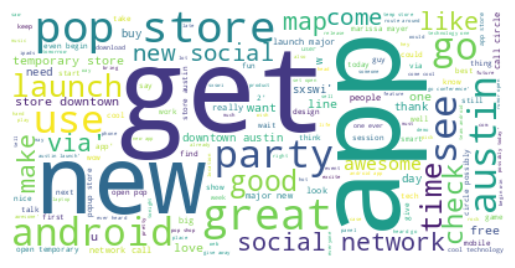

In [ ]:
# visualising wordcloud for positive sentiment tweets
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
# Preparing the negative tweets for the wordcloud
token_neg_tweets = [tweet_preprocessor(tweet, sw) for tweet in neg_tweets_text.astype(str)]

In [ ]:
neg_wordcloud = WordCloud(background_color="white", stopwords=sw).generate(str(token_neg_tweets))

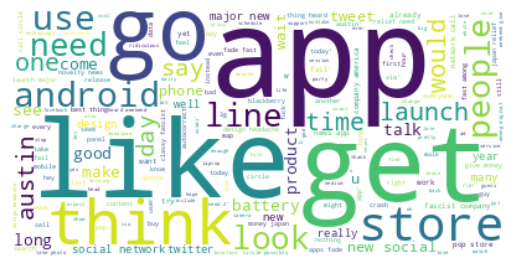

In [ ]:
# visualising wordcloud for negative sentiment tweets
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Above we can see which words are the most popular in either the positive or negative sentiment tweets. This just helps to get a flavour and indictation whether more pre-processing/stop words need to be added and removed to improve overall performance, however for now we'll look to proceed into the modelling stage of the project.

## Binary Classification - Positive & Negative Tweets only

First we look at only the binary classification problem, we se create a copy of the dataframe only including the positive & negative sentiment tweets. We can then use this to train_test_split our dataset and prepare it for modelling.

In [ ]:
# Building classification model which ignores all neutral based tweets
tweet_df_bin = tweet_df[tweet_df['category_id'].isin([0,1])]
X_bin = tweet_df_bin['tweet_text'].astype(str)
y_bin = tweet_df_bin['category_id']

In [ ]:
# Splitting the data into a training and test dataset to evaluate model performance
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_bin, y_bin, test_size =0.2, random_state=42, stratify=y_bin)

In [ ]:
# Preprocessing the training dataset
token_tweets = [tweet_preprocessor(tweet, sw) for tweet in X_train_bin]

In [ ]:
# Secondary train-test split to build our best model
X_t_bin, X_val_bin, y_t_bin, y_val_bin = train_test_split(token_tweets, y_train_bin,
                                          test_size=0.25, random_state=42, stratify=y_train_bin)

### CountVectorizer Multinomial Naive Bayes

In the following stages, we will start assessing various models & techniques performance for the classification problem, first starting with a binary classification problem.

This steps followed are:
- Prepare the train & validation datasets by fitting and transforming the training set and transform the validation set. Each iteration will use a different model, this one contains the CountVectorizer
- Once the datasets have been prepared, we want to use those transformed datasets in our classification model. This will give us our predictions for the model in question
- We take these predictions to compare against our validation target set to calculate several metrics such as accuracy_score and recall_score
- To understand overall performance we create and visualise the confusion matrix. This helps to visualise how many False Negatives & False Positives the model produces
- We then produce the classification report to see how the metrics vary for each class
- At the end, to store the models results, we append them into our models_performance list

After each iteration, we can use this process to see how well each model performs with our specific metric of the `recall_score` to  help choose the best performing model for our classification task.

In [ ]:
X_train_vec, X_val_vec = prepare_transformed_datasets(CountVectorizer(), X_t_bin, y_t_bin, X_val_bin, y_val_bin)

In [ ]:
prediction, model = train_predict_model(MultinomialNB(), X_train_vec, y_t_bin, X_val_vec)

In [ ]:
accuracy_score(y_val_bin, prediction)


0.8746478873239436

In [ ]:
cm = confusion_matrix(y_val_bin, prediction)
cm

array([[ 38,  76],
       [ 13, 583]])

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['negative','positive'], 
                     columns = ['negative','positive'])

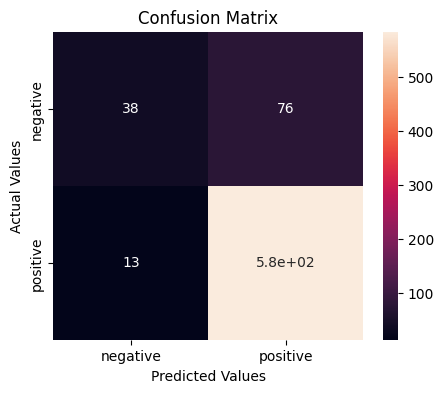

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
recall_count_mnb = recall_score(y_val_bin, prediction, average = 'weighted')
recall_count_mnb

0.8746478873239436

In [ ]:
print(metrics.classification_report(y_val_bin, prediction, digits=3))

              precision    recall  f1-score   support

           0      0.745     0.333     0.461       114
           1      0.885     0.978     0.929       596

    accuracy                          0.875       710
   macro avg      0.815     0.656     0.695       710
weighted avg      0.862     0.875     0.854       710



In [ ]:
models_performance.append(('CountVectMNB-Binary',recall_count_mnb))

Above we created our first classification model using CountVectorizer and Multinomial Naive Bayes. We then looked at the overall performance and the confusion matrix against our validation set, we can see that overall it was very successful in identifying positive sentiment tweets, however didn't perform as well on the negative sentiment scores. We can see this further by looking at the recall score, broken down by each classification, where only 33.3% of the negative sentiment tweets were actually labelled correctly.

Let's see if we can look at additional models that can help improve this overall recall score.



### Tf-idf Vectorizer Multinomial Naive Bayes

In [ ]:
X_train_vec, X_val_vec = prepare_transformed_datasets(TfidfVectorizer(), X_t_bin, y_t_bin, X_val_bin, y_val_bin)

In [ ]:
prediction, model = train_predict_model(MultinomialNB(), X_train_vec, y_t_bin, X_val_vec)

In [ ]:
accuracy_score(y_val_bin, prediction)

0.8492957746478873

In [ ]:
cm = confusion_matrix(y_val_bin, prediction)
cm

array([[  7, 107],
       [  0, 596]])

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['negative','positive'], 
                     columns = ['negative','positive'])

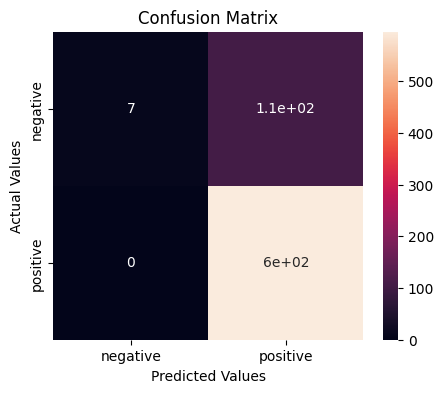

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
print(metrics.classification_report(y_val_bin, prediction, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.061     0.116       114
           1      0.848     1.000     0.918       596

    accuracy                          0.849       710
   macro avg      0.924     0.531     0.517       710
weighted avg      0.872     0.849     0.789       710



In [ ]:
recall_tfidf_mnb = recall_score(y_val_bin, prediction, average = 'weighted')

models_performance.append(('tfidfVectMNB-Binary',recall_tfidf_mnb))

Next I wanted to see if changing the transformation layer of the model might help improve overall performance, this time by trying the tf-idf Vectorizer. As we can see by both the confusion matrix and the classification report, our recall score has significantly dropped using this model, therefore we continue to look for other options below.

## Random Forest with Countvectorization

In [ ]:
X_train_vec, X_val_vec = prepare_transformed_datasets(CountVectorizer(), X_t_bin, y_t_bin, X_val_bin, y_val_bin)

In [ ]:
prediction, model = train_predict_model(RandomForestClassifier(n_estimators=1000, max_features=100, max_depth=10), X_train_vec, y_t_bin, X_val_vec)


In [ ]:
accuracy_score(y_val_bin, prediction)

0.8422535211267606

In [ ]:
cm = confusion_matrix(y_val_bin, prediction)
cm

array([[  2, 112],
       [  0, 596]])

In [ ]:
print(metrics.classification_report(y_val_bin, prediction, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.018     0.034       114
           1      0.842     1.000     0.914       596

    accuracy                          0.842       710
   macro avg      0.921     0.509     0.474       710
weighted avg      0.867     0.842     0.773       710



In [ ]:
recall_count_rf = recall_score(y_val_bin, prediction, average = 'weighted')

models_performance.append(('countVectRF-Binary',recall_count_rf))

When trying a different type of model, with the CountVectorizer method, we can see that overall performance on the binary classification model continues to not improve. As a result, we look to see if we can further expand our model to a multi-class classification model and what impact adding the additional class might have on overall performance.

## Multi-Classification Model

Now the Binary Classification problem has been iterated and the best performing model has been chosen, we want to move onto trying to see what impacts and performance dips we get when we introduce the `neutral` sentiment tweets into the datasets.

We will repeat the same steps as we did with the binary classification section. These are:

- Split the dataset into training & validation
- Preform the text preprocessing on the training dataset
- Choose a Vectoriser method that can be used to prepare the training & validation dataset
- Choose a classification model to test performance and compare it against the validation dataset
- Review metrics like `accuracy_score` and `recall_score`
- Produce a confusion matrix to visually understand which False positives and False Negatives are produced
- Create the `classification_report` to understand how the `recall_score` performs for each individual class
- Add the models performance in our overall `models_performance` list for final review & model selection

In [ ]:
X = tweet_df['tweet_text'].astype(str)
y = tweet_df['category_id']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42, stratify=y)

In [ ]:
token_tweets = [tweet_preprocessor(tweet, sw) for tweet in X_train]

In [ ]:
# Secondary train-test split to build our best model
X_t, X_val, y_t, y_val = train_test_split(token_tweets, y_train,
                                          test_size=0.25, random_state=42, stratify=y_train)


### CountVectorizer Multinomial Naive Bayes

In [ ]:
X_train_vec, X_val_vec = prepare_transformed_datasets(CountVectorizer(), X_t, y_t, X_val, y_val)

In [ ]:
prediction, model = train_predict_model(MultinomialNB(), X_train_vec, y_t, X_val_vec)

In [ ]:
accuracy_score(y_val, prediction)

0.6476510067114094

In [ ]:
cm = confusion_matrix(y_val, prediction)
cm

array([[ 16,  42,  56],
       [  1, 292, 303],
       [ 14, 214, 850]])

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['negative','positive','neutral'], 
                     columns = ['negative','positive','neutral'])

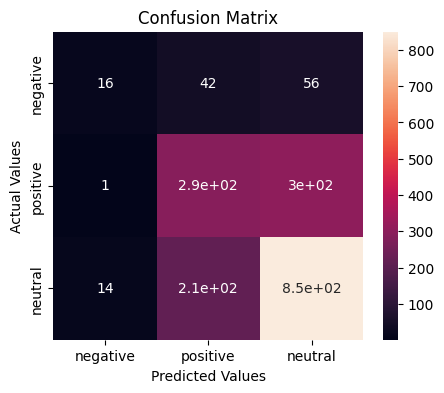

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
recall_count_multi_mnb = recall_score(y_val, prediction, average = 'weighted')

In [ ]:
print(metrics.classification_report(y_val, prediction, digits=3))

              precision    recall  f1-score   support

           0      0.516     0.140     0.221       114
           1      0.533     0.490     0.510       596
           2      0.703     0.788     0.743      1078

    accuracy                          0.648      1788
   macro avg      0.584     0.473     0.492      1788
weighted avg      0.634     0.648     0.632      1788



In [ ]:
models_performance.append(('CountVectMNB-Multi', recall_count_multi_mnb))

Following the same approach as the binary classification model, we first started with the highest performing combination to see overall performance and recall score. As we can see, adding in the neutral tweets have really skewed overall performance, with both the positive and negative tweets really struggling to be separated and recognised through the model.

### Tf-idf Vectorizer Multinomial Naive Bayes

In [ ]:
X_train_vec, X_val_vec = prepare_transformed_datasets(TfidfVectorizer(), X_t, y_t, X_val, y_val)

In [ ]:
prediction, model = train_predict_model(MultinomialNB(), X_train_vec, y_t, X_val_vec)

In [ ]:
accuracy_score(y_val, prediction)

0.651565995525727

In [ ]:
cm = confusion_matrix(y_val, prediction)
cm

array([[   5,   10,   99],
       [   0,  140,  456],
       [   0,   58, 1020]])

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['negative','positive','neutral'], 
                     columns = ['negative','positive','neutral'])

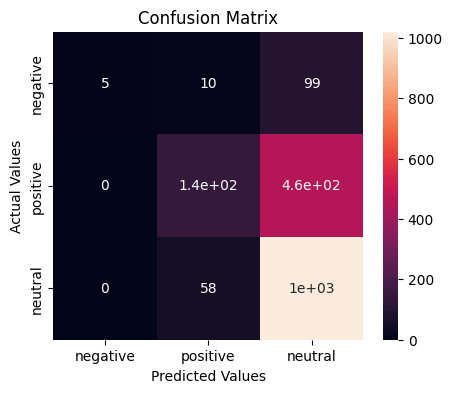

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
recall_tfidf_multi_mnb = recall_score(y_val, prediction, average = 'weighted')

In [ ]:
print(metrics.classification_report(y_val, prediction, digits=3))

              precision    recall  f1-score   support

           0      1.000     0.044     0.084       114
           1      0.673     0.235     0.348       596
           2      0.648     0.946     0.769      1078

    accuracy                          0.652      1788
   macro avg      0.774     0.408     0.400      1788
weighted avg      0.679     0.652     0.585      1788



In [ ]:
models_performance.append(('TfidfVectMNB-Multi', recall_tfidf_multi_mnb))

Here we can see performance continues to get worse with this model set up, so we continue to explore other options in boosting model performance.

### CountVectoriser & Tf-idf  Multinomial NB



In [ ]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_t)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

model = MultinomialNB()
clf = model.fit(X_train_tfidf, y_t)


In [ ]:
X_test_tf = count_vect.transform(X_val)
X_test_tfidf = tfidf_transformer.transform(X_test_tf)

predicted = model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_val, predicted))


Accuracy: 0.651565995525727


In [ ]:
cm = confusion_matrix(y_val, predicted)
cm

array([[   5,   10,   99],
       [   0,  140,  456],
       [   0,   58, 1020]])

In [ ]:
print(metrics.classification_report(y_val, predicted))


              precision    recall  f1-score   support

           0       1.00      0.04      0.08       114
           1       0.67      0.23      0.35       596
           2       0.65      0.95      0.77      1078

    accuracy                           0.65      1788
   macro avg       0.77      0.41      0.40      1788
weighted avg       0.68      0.65      0.59      1788



In [ ]:
recall_count_tfidf_multi_mnb = recall_score(y_val, predicted, average='weighted')

models_performance.append(('CountTfidfVectMNB-Multi', recall_count_tfidf_multi_mnb))

### RandomForest - Count Vectoriser

In [ ]:
X_train_vec, X_val_vec = prepare_transformed_datasets(CountVectorizer(), X_t, y_t, X_val, y_val)

In [ ]:
prediction, model = train_predict_model(RandomForestClassifier(n_estimators=5000, max_features=500, max_depth=10), X_train_vec, y_t, X_val_vec)


In [ ]:
accuracy_score(y_val, prediction)

0.639261744966443

In [ ]:
cm = confusion_matrix(y_val, prediction)
cm

array([[   0,    5,  109],
       [   0,   87,  509],
       [   0,   22, 1056]])

In [ ]:
cm_df = pd.DataFrame(cm,
                     index = ['negative','positive','neutral'], 
                     columns = ['negative','positive','neutral'])

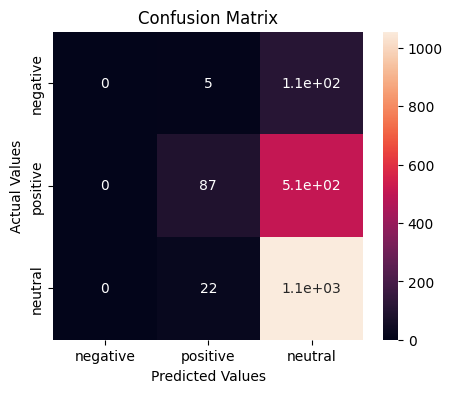

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
recall_count_rf_multi = recall_score(y_val, prediction, average = 'weighted')

In [ ]:
print(metrics.classification_report(y_val, prediction, digits=3))

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       114
           1      0.763     0.146     0.245       596
           2      0.631     0.980     0.767      1078

    accuracy                          0.639      1788
   macro avg      0.465     0.375     0.338      1788
weighted avg      0.635     0.639     0.544      1788



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
models_performance.append(('CountVectRF-Multi', recall_count_rf_multi))

We can see that this version of the model completely destroys overall recall score performance, especially when focusing on being able to identify negative sentiment tweets. So now we can look at the list of variations all in one table to understand which model combination drove the base performance and whether it improved against the baseline model.

In [ ]:
models_performance_df = pd.DataFrame(models_performance, columns = ['Model Name', 'Recall Score'])

models_performance_df

,Model Name,Recall Score
0,Baseline-model,0.605615
1,CountVectMNB-Binary,0.874648
2,tfidfVectMNB-Binary,0.849296
3,countVectRF-Binary,0.842254
4,CountVectMNB-Multi,0.647651
5,TfidfVectMNB-Multi,0.651566
6,CountTfidfVectMNB-Multi,0.651566
7,CountVectRF-Multi,0.639262


## Model Evaluation

After evaluating several different transformations and models, with a focus on optimising towards our recall score, we are getting varied results, this could be due to several reasons, however the main one to call out is the fact that the initial dataset is heavily imbalanced towards the neutral tweet compared to the negative sentiment tweets. As a result on all of the models trialled the negative sentiment category always had the lowest results. 

The best performing model on both occassions has been the `CountVectorizer Multinomial Naive Bayes` model. This is because we want to focus on maxising the recall score for our negative sentiment tweets, which can be better seen in the classification report of each model.

## Future steps & Limitations

In order to further refine the model in the future, the following limitations need to be addressed:

- Collect more data that allows the class imbalance between categories to be more balanced

Improvements could be made by switching approach from trialling out supervised ML models such as logisitic regression, RandomForest and Multinomial Naive Bayes. Instead it is worth testing out a CNN approach using more advanced techniques such as gensim, GloVe and Word2Vec to help us the hidden layer inside the neural networks to better make the connection between the context of the tweet and the overall sentiment

## Recommendations

Looking back to the use cases that this project held, the main recommendations on how to utilise this project are listed below:

- Continue to further iterate on the model to improve overall recall and accuracy scores to a threshold we're happy with this can first be handled by reducing the class imbalance within the training dataset and then trying to build neural networks for the model, afterwards
- Look to set up business practices that help to monitor all social media engagement and highlight when any negative comments are raised about the brand or specific product
- Establish a ways of working where teams further investigate the negative comments to perform root cause analysis and present back to product/leadership teams on a regular basis